# Script to plot FUTURE SPEI (multiple models)

- Author: Jess Baker (j.c.baker@leeds.ac.uk)
- adapted from Sarah's Chapman's notebook
- includes code from Eszter's drought notebook
- adapted 'make_cmip6_filepath' function to accomodate multiple model fpaths
- code to get the institute for each model

Some useful links
https://towardsdatascience.com/basic-data-structures-of-xarray-80bab8094efa

In [1]:
import os
import numpy as np
import xarray as xr
import glob
import datetime
from datetime import datetime as dt
from pyhdf.SD import SD, SDC
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import cf_units
import pandas as pd
import copy
import climate_indices
from climate_indices import compute, indices
import iris
from netCDF4 import date2num
import iris.coord_categorisation
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units

import os 

def get_dates(cube, verbose=False):
    dates = cube.coord('time').units.num2date(cube.coord('time').points)
    dates = [dt(date.year, date.month, date.day) for date in dates]
    if verbose is True:
        print(dates)
    else:
        print(dates[0], '–', dates[-1])
    return(dates)


def merge_hist_future_cmip6(hist_cube, future_cube):
    # combine hist and future data into single cube
    hist_dates = get_dates(hist_cube)
    calendar = 'gregorian'
    units = 'days since ' + str(hist_dates[0].year) + '-01-01 00:00:0.0'
    
    future_dates = get_dates(future_cube)
    
    if future_dates[0].year <= hist_dates[-1].year:
        # if future and historical cubes overlap remove overlap
        print(hist_dates[0].year)
        print(future_dates[0].year)
        hist_constraint = iris.Constraint(time=lambda cell: hist_dates[0].year <= cell.point.year < future_dates[0].year)
        hist_cube = hist_cube.extract(hist_constraint)
        hist_dates = get_dates(hist_cube)
        
    dates = hist_dates + future_dates
    
    # get time dimension
    times = date2num(dates, units=units, calendar=calendar)
    time_unit = cf_units.Unit(units, calendar=calendar)
    time = iris.coords.DimCoord(times, standard_name='time',
                                units=time_unit)

    lats = future_cube.coord('latitude').points
    latitude = iris.coords.DimCoord(lats, standard_name='latitude',
                                    units='degrees')
    lons = future_cube.coord('lon').points
    longitude = iris.coords.DimCoord(lons, standard_name='longitude',
                                     units='degrees')
    new_data = np.zeros((len(dates), len(lats), len(lons)))
    
    # add historical data
    new_data[0:hist_cube.shape[0], :, :] = hist_cube.data
    new_data[hist_cube.shape[0]:, :, :] = future_cube.data
    
    # Put data into data cube
    cube = iris.cube.Cube(new_data, var_name=future_cube.standard_name,
                          units=future_cube.units,
                          dim_coords_and_dims=[(time, 0), (latitude, 1),
                                               (longitude, 2)])
    print(cube)
    return(cube)

def cube_to_frame(cube_dict, expt='hist'): # set up in case calculate SPEI for multiple models
    df = pd.DataFrame(columns = ['model', 'expt', 'year', 'month', 'value'])
    
    for key in cube_dict.keys():
        cube = cube_dict[key].copy()
        cube_time_mean = cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
        model = key #extract from attributes later
        
        x = cube_time_mean.data
        x = x[~x.mask].flatten() #if masked to land sea, which isn't as moment
        
        iris.coord_categorisation.add_year(cube_time_mean, 'time', name='year')
        iris.coord_categorisation.add_month(cube_time_mean, 'time', name='month')
        
        year =  cube_time_mean.coord('year').points
        #print(year)
        month = cube_time_mean.coord('month').points
        
        y = pd.DataFrame(columns =   ['model', 'expt', 'year', 'month', 'value'])
       
        y['value'] = x
        y['year'] = year
        y['model'] = model
        y['expt'] = expt
        y['month'] = month
        
        df= df.append(y)
    
    return(df)


def make_cmip6_filepath(institute, model, scenario, variant, experiment, table_id, variable, grid, version, time_range,
                        data_root="/badc/cmip6/data/CMIP6/"):
    """
    Make a file path for a cmip6 dataset for a single variable
    Historical runs (1850-2014) are in `/badc/cmip6/data/CMIP6/CMIP/<institute>/<model>/historical/<variant>/<table_id>/<variable>/<grid>/<version>/`
    Scenario runs are in `/badc/cmip6/data/CMIP6/ScenarioMIP/<institute>/<model>/<scenario_name>/<variant>/<table_id>/<variable>/<grid>/<version>/`
    `scenario_name` is likely to be one of ssp119, ssp126, ssp245, ssp370 or ssp585
    `variant` takes the form `r<realiation_id>0<initialization_id>0<physics_id>0<forcing_id>`, e.g. `r1i1p1f2`, where the numbers are the indexes for:  
    **r**ealization, **i**nitialization, **p**hysics, **f**orcing
    `table_id` generally indicates the frequency of the data, e.g. day, 3hr, Amon
    `grid` is the model grid being used, e.g. gn, where  
       * `gm`: global mean data  
       * `gn`: data reported on a model's native grid  
       * `gr1`: regridded data reported on a grid other than the native grid and other than the preferred target grid  
    It is likely the `grid` will be the native grid, i.e. `gn`
    `version` normally in the form `v[YYYYMMDD]` or `latest`, e.g. `v20200203
    
    `variable` generally follows the list on https://pcmdi.llnl.gov/mips/cmip3/variableList.html, for example 
       `tas`: air_temperature 
       `pr`: precipitation_flux
       `ts`: surface_temperature
    The following institutions have data in both historical and ScenarioMIPs:
    AS-RCEC, AWI, BCC, CAMS, CAS, CCCR-IITM, CCCma, CMCC, CNRM-CERFACS, CSIRO, CSIRO-ARCCSS, E3SM-Project, EC-Earth-Consortium, FIO-QLNM, HAMMOZ-Consortium, INM, IPSL, KIOST, MIROC, MOHC, MPI-M, MRI, NASA-GISS, NCAR, NCC, NIMS-KMA, NOAA-GFDL, NUIST, THU, UA
    """
    # get base path
    path = str(DATA_ROOT / scenario / institute / model / experiment)
    print(path)
    #print(os.listdir(path))
    
    # get path for variant
    if variant is None:
        # select first variant
        dir_list = os.listdir(path)
        variant_list = [x for x in dir_list if x.startswith('r')]
    else:
        variant_list = [variant]
    
    # update path
    var = [x for x in variant_list if x.startswith('r1i1p1')]
    if len(var) == 0:
        print(variant_list)
        var = [x for x in variant_list if x.startswith('r')]
        path = path + '/' + var[0] + '/' + str(table_id) + '/' + str(variable)
    else:
        path = path + '/' + var[0] + '/' + str(table_id) + '/' + str(variable) 
    print(path)
    # get path for grid
    if grid is None:
        # select first grid (usually only 1)
        dir_list = os.listdir(path)
        grid_list = [x for x in dir_list if x.startswith('g')]
    else:
        grid_list = [grid]
        
    # update path
    path = path + '/' + str(grid_list[0])
    print(path)
    
    # get version path
    if version is None:
        dir_list2 = os.listdir(path)
        version_list = [x for x in dir_list2 if x.startswith('v')]
    else:
        version_list = [version]
    
    # update path
    path = path + '/' + str(version_list[0]) + '/'
    print(path)
    print(os.listdir(path))
    return(path+ '*.nc')

# test
DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")
model = "UKESM1-0-LL"
expt = 'ssp585'
scenario = 'ScenarioMIP'
fp = make_cmip6_filepath(
        institute="MOHC", scenario=scenario, model=model, experiment=expt, variant=None,
        table_id="Amon", variable="pr", grid=None, version=None, time_range="*"
    )

/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/pr
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/pr/gn
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/pr/gn/v20190507/
['pr_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc', 'pr_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc']


In [2]:
# load dicts saved in other script
expt = 'ssp119'
path = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
calib_year_init = 1980
calib_year_final = 2010
spei_dict = np.load(path+ 'hist_'+expt+'_all_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib.npy').item()
spei_north_dict = np.load(path+ 'hist_'+expt+'_n_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib.npy').item()
spei_south_dict = np.load(path+ 'hist_'+expt+'_s_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib.npy').item()

#turn into dataframe and extract year
spei_df = cube_to_frame(spei_dict, expt=expt)
print(spei_df.head(3))
spei_north_df = cube_to_frame(spei_north_dict, expt=expt)
print(spei_north_df.head(3))
spei_south_df = cube_to_frame(spei_south_dict, expt=expt)
print(spei_south_df.head(3))

         model    expt  year month     value
0  CAMS-CSM1-0  ssp119  1980   Jan -0.164366
1  CAMS-CSM1-0  ssp119  1980   Feb -0.132465
2  CAMS-CSM1-0  ssp119  1980   Mar -0.233166
         model    expt  year month     value
0  CAMS-CSM1-0  ssp119  1980   Jan -0.143997
1  CAMS-CSM1-0  ssp119  1980   Feb -0.082396
2  CAMS-CSM1-0  ssp119  1980   Mar -0.118524
         model    expt  year month     value
0  CAMS-CSM1-0  ssp119  1980   Jan -0.184735
1  CAMS-CSM1-0  ssp119  1980   Feb -0.182535
2  CAMS-CSM1-0  ssp119  1980   Mar -0.347808


AssertionError: 

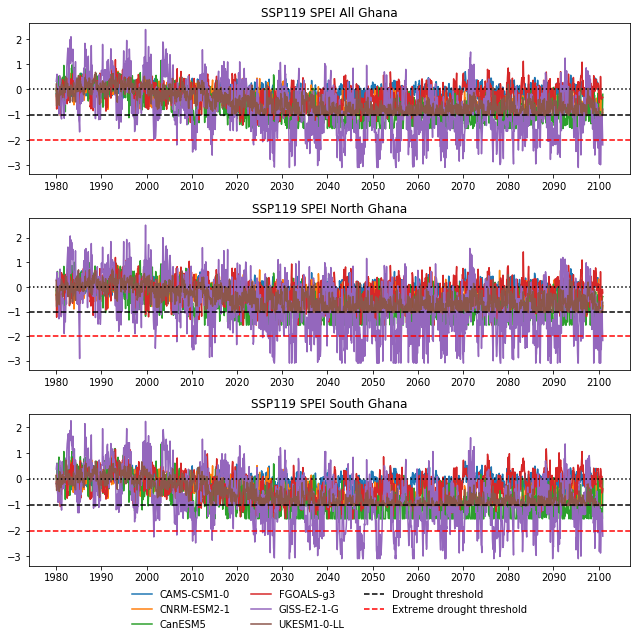

In [7]:
##plot time series
fig = plt.figure(figsize = (9,9))
ax =  fig.add_subplot(311)
ax2 =  fig.add_subplot(311)
ax3 =  fig.add_subplot(311)

titles = [' All Ghana', ' North Ghana', ' South Ghana']

subplot = 1
for df in [spei_df, spei_north_df, spei_south_df]:
    ax = fig.add_subplot(3, 1, subplot)
    for model in np.unique(df['model'])[0:]:
        #print(model)
        #fig = plt.figure(figsize = (9,6))
        #ax =  fig.add_subplot(111)
        #continue
        years =  np.unique(df['year'])
        #print(years)
        #print(len(df[df.model==model]))
        #assert False
        ax.plot(df['value'][df.model==model], label=model)#, c = 'black', label=model)
        #ax.set_title(model)

    ax.set_xticks(np.arange(0, len(df[df.model==model]), 120))
    ax.set_xticklabels(years[::10])
    ax.axhline(y = 0, color = 'black', linestyle = 'dotted')
    ax.axhline(y = -1, color = 'black', linestyle = 'dashed', label = 'Drought threshold')
    ax.axhline(y = -2, color = 'red', linestyle = 'dashed', label = 'Extreme drought threshold')
    ax.set_title(expt.upper() + ' SPEI' + titles[subplot-1]) 

    subplot += 1

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.10), ncol = 3, frameon = False)

plt.tight_layout()
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/' + expt + '_spei_multi_model.png'
plt.savefig(outpath, dpi=300, bbox_inches='tight')
assert False